[Baseline from Wilson](https://arxiv.org/pdf/2002.08791.pdf)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano
import theano.tensor as tt

## Make. the Data

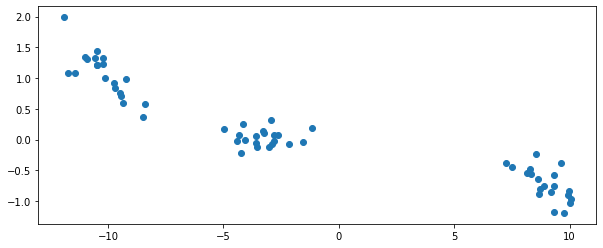

In [2]:
random_state = np.random.RandomState(42)

def fake_model(x, noise=True):
    y = -x**3 + x 
    if noise:
        y += random_state.normal(0, 200, y.shape[0])
    return y

cluster_sample_size = 20

x = np.concatenate([
    random_state.normal(-10, 1, cluster_sample_size),
    random_state.normal(-3, 1, cluster_sample_size),
    random_state.normal(9, 1, cluster_sample_size),
], axis=0)

y = fake_model(x) / 1000

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

plt.figure(figsize=(10, 4))
plt.scatter(x, y)
plt.show()

## MCMC Example

In [10]:
input_dim = x.shape[1]
output_dim = y.shape[1]

ann_input = theano.shared(x)
ann_output = theano.shared(y)

n_hidden = 3

    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(input_dim, n_hidden))#, testval=init_1)
    weights_b_1 = pm.Normal('w_b_1', 0, sd=1, shape=(n_hidden))#, testval=init_b_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden))#, testval=init_2)
    weights_b_2 = pm.Normal('w_b_2', 0, sd=1, shape=(n_hidden))#, testval=init_b_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden, output_dim))#, testval=init_out)
    weights_b_out = pm.Normal('w_b_out', 0, sd=1, shape=(output_dim))#, testval=init_b_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + weights_b_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + weights_b_2)
    act_out = pm.math.dot(act_2, weights_2_out) + weights_b_out
        
    variance = pm.HalfNormal('uncertainty', sigma=3.0)    
    out = pm.Normal('out', mu=act_out, 
                    sigma=variance, 
                    observed=ann_output)

In [11]:
with neural_network:
    step = pm.NUTS()
    trace = pm.sample(1000, tune=100, 
                      cores=1, 
                      chains=1, 
                      step=step)
    
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     #s.set_value(0)
#     approx = pm.fit(n=20000, method=inference)
#     trace = approx.sample(draws=5000)

    approx = pm.fit(n=50000, method='svgd')
    trace = approx.sample(draws=20000)

Sequential sampling (1 chains in 1 job)
NUTS: [uncertainty, w_b_out, w_2_out, w_b_2, w_1_2, w_b_1, w_in_1]
Sampling chain 0, 30 divergences: 100%|██████████| 1100/1100 [01:39<00:00, 11.01it/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6229651992044711, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
100%|██████████| 50000/50000 [04:32<00:00, 183.44it/s]


In [12]:
def sample_posterior(x, trace, samples):
    posterior_samples = trace['w_in_1'].shape[0]
    output = []
    for _ in range(samples):
        i = np.random.randint(posterior_samples)
        act_1 = np.tanh(np.dot(x, trace['w_in_1'][i]) + trace['w_b_1'][i])
        act_2 = np.tanh(np.dot(act_1, trace['w_1_2'][i]) + trace['w_b_2'][i])
        y = np.dot(act_2, trace['w_2_out'][i]) + trace['w_b_out'][i]
        output.append(y)
    return np.asarray(output)

/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:05<00:00, 99.10it/s] 


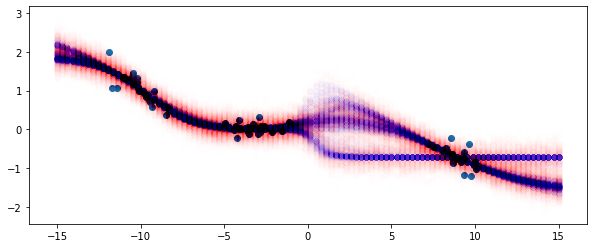

In [13]:
new_x = np.linspace(-15, 15, 100)[:, None].astype("float32")

p = sample_posterior(new_x,  trace, 500)

ann_input.set_value(new_x)
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

y_pred = ppc["out"].mean(axis=0)[:, None]

plt.figure(figsize=(10, 4))

# data
plt.scatter(x[:,0], y[:, 0])

# posterior
for i in range(p.shape[0]):
    plt.scatter(new_x[:, 0], p[i,:], alpha=0.005, c="b")

# posterior predictive
for i in range(ppc["out"].shape[0]):
    plt.scatter(new_x[:, 0], ppc["out"][i,:], alpha=0.005, c="r")

# mean of posterior / posterior predictive
#plt.scatter(new_x[:, 0], y_pred[:, 0])
plt.show()

## VI Example

In [18]:
input_dim = x.shape[1]
output_dim = y.shape[1]

ann_input = theano.shared(x)
ann_output = theano.shared(y)

n_hidden = 3

    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(input_dim, n_hidden))#, testval=init_1)
    weights_b_1 = pm.Normal('w_b_1', 0, sd=1, shape=(n_hidden))#, testval=init_b_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden))#, testval=init_2)
    weights_b_2 = pm.Normal('w_b_2', 0, sd=1, shape=(n_hidden))#, testval=init_b_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden, output_dim))#, testval=init_out)
    weights_b_out = pm.Normal('w_b_out', 0, sd=1, shape=(output_dim))#, testval=init_b_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + weights_b_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + weights_b_2)
    act_out = pm.math.dot(act_2, weights_2_out) + weights_b_out
        
    variance = pm.HalfNormal('uncertainty', sigma=3.0)    
    out = pm.Normal('out', mu=act_out, 
                    sigma=variance, 
                    observed=ann_output)

In [19]:
with neural_network:
    
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     #s.set_value(0)
#     approx = pm.fit(n=20000, method=inference)
#     trace = approx.sample(draws=5000)

    approx = pm.fit(n=10000, method='svgd')
    trace = approx.sample(draws=20000)

100%|██████████| 10000/10000 [00:53<00:00, 187.20it/s]


/Users/jamesmontgomery/opt/anaconda3/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 500/500 [00:05<00:00, 96.12it/s] 


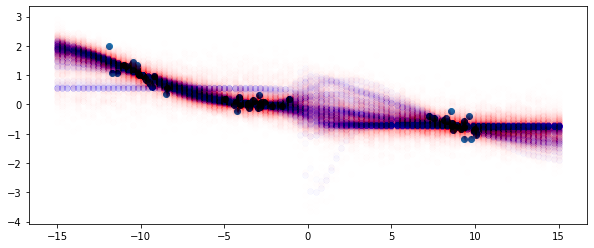

In [20]:
new_x = np.linspace(-15, 15, 100)[:, None].astype("float32")

p = sample_posterior(new_x,  trace, 500)

ann_input.set_value(new_x)
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

y_pred = ppc["out"].mean(axis=0)[:, None]

plt.figure(figsize=(10, 4))

# data
plt.scatter(x[:,0], y[:, 0])

# posterior
for i in range(p.shape[0]):
    plt.scatter(new_x[:, 0], p[i,:], alpha=0.005, c="b")

# posterior predictive
for i in range(ppc["out"].shape[0]):
    plt.scatter(new_x[:, 0], ppc["out"][i,:], alpha=0.005, c="r")

# mean of posterior / posterior predictive
#plt.scatter(new_x[:, 0], y_pred[:, 0])
plt.show()

## MCDropout Example

## Ensemble Example